# 事前準備

In [111]:
import os
from tqdm import tqdm
import psutil
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn import preprocessing

import mca
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import optuna

from sklearn.ensemble import RandomForestClassifier as RFC
import lightgbm

DATA_PATH = os.getcwd()+'/data/'
SUBMISSION_PATH = os.getcwd()+'/submission/'

In [3]:
# オリジナルの呼び出し
train_data = pd.read_csv(DATA_PATH+'train.csv', dtype=np.int16).drop('Id',axis=1)
test_data = pd.read_csv(DATA_PATH+'test.csv', dtype=np.int16).drop('Id',axis=1)

In [112]:
# ダウンサンプリング + PCA + SS を適用したデータの呼び出し
train_data = pd.read_csv(DATA_PATH+'train_pca_ss.csv', dtype=np.float32).drop('Unnamed: 0',axis=1)
test_data = pd.read_csv(DATA_PATH+'test_pca_ss.csv', dtype=np.float32).drop('Unnamed: 0',axis=1)

In [113]:
# メモリ容量を取得
mem = psutil.virtual_memory()
print(mem.total)
print(mem.available)

2082197504
745517056


# データの確認

In [6]:
train_data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,3189,40,8,30,13,3270,206,234,193,4873,...,0,0,0,0,0,0,0,0,0,1
1,3026,182,5,280,29,3270,233,240,106,5423,...,0,0,0,0,0,0,0,0,0,2
2,3106,13,7,351,37,2914,208,234,137,5269,...,0,0,0,0,0,0,0,0,0,1
3,3022,276,13,192,16,3034,207,238,156,2866,...,0,0,0,0,0,0,0,0,0,2
4,2906,186,13,266,22,2916,231,231,154,2642,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,2954,34,25,51,65,6314,240,237,103,1618,...,0,0,0,0,0,0,0,0,0,2
3999996,2926,104,8,696,83,5427,210,216,150,2863,...,0,0,0,0,0,0,0,0,0,2
3999997,2911,144,1,509,58,4820,195,192,91,92,...,0,0,0,0,0,0,0,1,0,2
3999998,2580,178,17,376,86,2592,225,183,39,1374,...,0,0,0,0,0,0,0,0,0,3


In [25]:
# 欠損値チェック
train_data.isnull().any()

Elevation                             False
Aspect                                False
Slope                                 False
Horizontal_Distance_To_Hydrology      False
Vertical_Distance_To_Hydrology        False
Horizontal_Distance_To_Roadways       False
Hillshade_9am                         False
Hillshade_Noon                        False
Hillshade_3pm                         False
Horizontal_Distance_To_Fire_Points    False
Wilderness_Area1                      False
Wilderness_Area2                      False
Wilderness_Area3                      False
Wilderness_Area4                      False
Soil_Type1                            False
Soil_Type2                            False
Soil_Type3                            False
Soil_Type4                            False
Soil_Type5                            False
Soil_Type6                            False
Soil_Type7                            False
Soil_Type8                            False
Soil_Type9                      

In [6]:
test_data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2763,78,20,377,88,3104,218,213,195,1931,...,0,0,0,0,0,0,0,0,0,0
1,2826,153,11,264,39,295,219,238,148,2557,...,0,0,0,0,0,0,0,0,0,0
2,2948,57,19,56,44,852,202,217,163,1803,...,0,0,1,0,0,0,0,0,0,0
3,2926,119,6,158,134,2136,234,240,142,857,...,0,0,0,0,0,0,0,0,0,0
4,2690,10,4,38,108,3589,213,221,229,431,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2974,254,15,146,100,623,222,245,117,2353,...,0,0,0,0,0,0,0,0,0,0
999996,3180,92,16,93,47,3740,209,201,142,356,...,0,0,0,0,0,0,0,0,1,0
999997,2684,51,20,34,123,962,199,225,145,350,...,0,0,0,0,1,0,0,0,0,0
999998,3309,64,12,196,93,2522,226,193,74,3300,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# 欠損値チェック
test_data.isnull().any()

Elevation                             False
Aspect                                False
Slope                                 False
Horizontal_Distance_To_Hydrology      False
Vertical_Distance_To_Hydrology        False
Horizontal_Distance_To_Roadways       False
Hillshade_9am                         False
Hillshade_Noon                        False
Hillshade_3pm                         False
Horizontal_Distance_To_Fire_Points    False
Wilderness_Area1                      False
Wilderness_Area2                      False
Wilderness_Area3                      False
Wilderness_Area4                      False
Soil_Type1                            False
Soil_Type2                            False
Soil_Type3                            False
Soil_Type4                            False
Soil_Type5                            False
Soil_Type6                            False
Soil_Type7                            False
Soil_Type8                            False
Soil_Type9                      

(array([1.468136e+06, 2.262087e+06, 0.000000e+00, 1.957120e+05,
        0.000000e+00, 3.770000e+02, 1.000000e+00, 0.000000e+00,
        1.142600e+04, 6.226100e+04]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

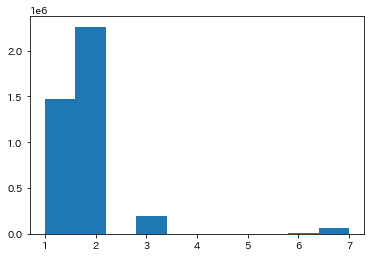

In [7]:
plt.hist(train_data['Cover_Type'])

In [5]:
print('------------- train data -------------')
for i in range(7):
    print("Cover_Type{}: {}".format(i+1, len(train_data[train_data['Cover_Type']==(i+1)])))

------------- train data -------------
Cover_Type1: 1468136
Cover_Type2: 2262087
Cover_Type3: 195712
Cover_Type4: 377
Cover_Type5: 1
Cover_Type6: 11426
Cover_Type7: 62261


# わかったこと

- 不均衡データによる多クラス分類  
  → 評価関数を工夫する  
  → マージン最大化を利用する  
  → ダウンサンプリング(Type4に合わせる)
- 説明変数の一部がスパース  
  → 多重対応分析による特徴量抽出  

# ベースライン

## 前処理

In [66]:
#説明変数
train_ex = train_data.drop('Cover_Type', axis=1)
#目的変数
train_ob = train_data['Cover_Type']

In [64]:
# 標準化
ss = preprocessing.StandardScaler()
train_ss = pd.DataFrame(ss.fit_transform(train_ex), index=train_ex.index, columns=train_ex.columns)

In [70]:
# 標準化
ss = preprocessing.StandardScaler()
test_ss = pd.DataFrame(ss.fit_transform(test_data), index=test_data.index, columns=test_data.columns)

In [65]:
train_ss

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.722400,-1.014774,-0.830439,-1.065177,-0.566768,1.142708,-0.189777,0.581997,1.194297,2.919073,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
1,0.158480,0.276592,-1.181450,0.038334,-0.332219,1.142708,0.687987,0.851886,-0.796612,3.406827,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
2,0.435250,-1.260315,-0.947443,0.351731,-0.214944,0.872111,-0.124758,0.581997,-0.087208,3.270256,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
3,0.144641,1.131439,-0.245420,-0.350102,-0.522790,0.963324,-0.157268,0.761923,0.347588,1.139212,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
4,-0.256676,0.312968,-0.245420,-0.023463,-0.434834,0.873632,0.622968,0.447052,0.301820,0.940562,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,-0.090613,-1.069339,1.158626,-0.972482,0.195517,3.456465,0.915556,0.716941,-0.865264,0.032452,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
3999996,-0.187483,-0.432750,-0.830439,1.874576,0.459385,2.782252,-0.059738,-0.227671,0.210284,1.136551,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
3999997,-0.239378,-0.068985,-1.649466,1.049150,0.092902,2.320869,-0.547385,-1.307229,-1.139873,-1.320846,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,4.948200,-0.180696
3999998,-1.384516,0.240215,0.222595,0.462082,0.503363,0.627358,0.427909,-1.712063,-2.329841,-0.183934,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696


In [71]:
test_ss

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,-0.602909,-0.664981,0.600277,0.494061,0.532977,1.011325,0.202692,-0.386123,1.214559,0.219114,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
1,-0.419062,0.006883,-0.463930,-0.001615,-0.182141,-1.031701,0.234661,0.752728,0.179271,0.735520,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
2,-0.063040,-0.853103,0.482031,-0.914009,-0.109170,-0.626587,-0.308810,-0.203907,0.509682,0.113523,...,-0.174766,-0.213039,4.860751,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
3,-0.127241,-0.297695,-1.055157,-0.466585,1.204312,0.307285,0.714194,0.843836,0.047107,-0.666860,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
4,-0.815938,-1.274138,-1.291647,-0.992966,0.824862,1.364072,0.042848,-0.021691,1.963491,-1.018280,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.012833,0.911661,0.009050,-0.519223,0.708108,-0.793142,0.330568,1.071607,-0.503579,0.567235,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
999996,0.613984,-0.539567,0.127296,-0.751708,-0.065388,1.473897,-0.085028,-0.932772,0.047107,-1.080150,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,4.909152,-0.184089
999997,-0.833448,-0.906852,0.600277,-1.010512,1.043775,-0.546582,-0.404717,0.160525,0.113189,-1.085100,...,-0.174766,-0.213039,-0.205730,-0.110926,7.901116,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
999998,0.990433,-0.790396,-0.345685,-0.299898,0.605948,0.588028,0.458443,-1.297204,-1.450757,1.348443,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089


## モデル

In [68]:
lgbm = lightgbm.LGBMClassifier()

In [69]:
lgbm.fit(train_ss, train_ob)

LGBMClassifier()

In [73]:
y_pred = lgbm.predict(test_ss)

In [79]:
submission = pd.DataFrame([np.arange(4000000,5000000), y_pred], index=['Id','Cover_Type']).T

In [83]:
submission.to_csv(SUBMISSION_PATH+"baseline.csv", index=False)

評価値: 0.89983

# 実験

やることとして
1. ダウンサンプリング: trainデータをダウンサンプリング(Type:4に合わせる)
1. ~~多重対応分析: trainとtestを対象に，バイナリ変数に多重対応分析~~
    1. ~~一度にできないので，ランダムサンプリングし，最後に平均する~~
    1. ~~標準化: 全データに対して標準化を適用~~  
    1. ~~ここで，trainとtestを別途保存する~~
1. 主成分分析: あんま意味ないと思うけど，一応やっとく  
    1. 標準化: 全データに対して標準化を適用  
    1. ここで，trainとtestを別途保存する
1. アンサンブル学習: アンサンブル学習(LightGBM, SVMとか？)
    1. とりあえず，いろんなモデルを試してみよう！  
    1. アンサンブルに使うモデルを選定
    1. パラメータチューニング
1. testデータの適用

## ダウンサンプリング

In [46]:
# ランダムサンプリングでやります

train_ds = []
for i in range(7):
    cover_type = train_data[train_data['Cover_Type']==(i+1)]
    if (i+1) == 5:
        train_ds.append(cover_type)
        continue
    train_ds.append(cover_type.sample(n=377, random_state=0))
train_ds = pd.concat(train_ds).reset_index(drop=True)

In [47]:
train_ds

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,3253,2,9,119,8,1977,246,212,132,6804,...,0,0,0,0,0,0,0,0,0,1
1,3211,86,13,353,22,1304,215,223,-6,2540,...,0,0,0,0,0,0,0,0,0,1
2,3261,160,13,1344,20,3340,226,242,141,2571,...,0,0,0,0,0,0,0,0,0,1
3,3485,23,23,179,100,3321,203,239,174,1983,...,0,0,0,0,0,0,0,0,0,1
4,3371,19,17,352,22,3995,167,220,114,2175,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,3583,42,15,63,80,3306,228,232,160,1137,...,0,0,0,0,0,0,1,0,0,7
2259,3333,64,4,446,9,993,224,211,183,104,...,0,0,0,1,0,0,0,0,0,7
2260,3503,350,27,266,88,1792,218,148,151,2011,...,1,0,0,0,0,0,0,0,0,7
2261,3323,92,9,336,200,-11,208,231,166,595,...,0,0,0,0,0,0,0,1,0,7


### データの成形

In [50]:
mca_targ = pd.concat([train_ds.iloc[:,10:-1],test_data.iloc[:,10:]])
mca_targ.index.name = "ID"
mca_targ

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
999997,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## 多重対応分析

### MCAの適用

In [59]:
stock = []
for i in tqdm(range(40000)):
    mca_counts = mca.MCA(train_data.sample(n=1000))
    rows = mca_counts.fs_r(N=5)  # 表側データ
    stock.append(rows)

100%|██████████| 40000/40000 [2:18:18<00:00,  4.82it/s]  


In [62]:
stock[0]

array([[ 0.06217426,  0.04923935],
       [-0.01771083,  0.06698257],
       [-0.01473002,  0.0959528 ],
       ...,
       [-0.05300595, -0.08317832],
       [ 0.04099149,  0.0451792 ],
       [-0.08582034,  0.01763725]])

In [63]:
mca_output = pd.concat(stock)
mca_output.index.name = "ID"
mca_output.sort_index(inplace=True)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [ ]:
mca_result = mca_output.groupby("ID").mean()

In [ ]:
# ここで結合もする

## 主成分分析

In [73]:
pca = PCA(n_components=21, random_state=0)
pca.fit(mca_targ)
print(sum(pca.explained_variance_ratio_))

0.8005384640472355


In [74]:
pca_result = pca.fit_transform(mca_targ)

In [80]:
pd.DataFrame(pca_result)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.535960,-0.147559,-0.116920,-0.084709,0.061977,-0.044211,-0.054743,-0.015430,-0.010363,-0.028805,...,-0.060893,-0.006174,-0.003734,-0.016724,-0.043711,-0.048997,-0.009520,-0.034362,-0.040869,-0.094170
1,-0.557427,0.712696,0.064416,-0.011341,-0.021344,-0.004720,-0.050285,-0.021411,0.002565,-0.046739,...,-0.101544,-0.008303,-0.008590,-0.025919,-0.051175,-0.046004,-0.017962,-0.041168,-0.039039,0.002208
2,-0.433909,-0.265061,-0.081437,-0.023352,-0.063405,-0.020485,-0.065878,-0.000487,0.001106,-0.063998,...,-0.132514,0.015870,0.002833,-0.036107,-0.068007,-0.043719,0.009635,-0.050336,-0.052866,-0.088597
3,-0.564240,0.705232,0.044111,-0.024428,-0.056395,-0.005848,-0.066237,-0.002848,0.015791,-0.076896,...,-0.205369,0.025651,-0.678698,0.557012,0.334577,0.114789,-0.096245,0.041929,0.005724,0.021760
4,0.535960,-0.147559,-0.116920,-0.084709,0.061977,-0.044211,-0.054743,-0.015430,-0.010363,-0.028805,...,-0.060893,-0.006174,-0.003734,-0.016724,-0.043711,-0.048997,-0.009520,-0.034362,-0.040869,-0.094170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002258,-0.437754,-0.265731,-0.082588,-0.023554,-0.062657,-0.010596,-0.059741,0.004311,0.005639,-0.067909,...,-0.122456,-0.001869,-0.003503,-0.034482,-0.064460,-0.030679,0.002238,-0.041013,-0.059266,-0.008264
1002259,-0.433174,-0.262970,-0.100267,0.011924,-0.113737,-0.026217,-0.042211,0.047198,0.051027,-0.071154,...,0.352348,-0.014995,0.002148,-0.020084,-0.077678,-0.047687,-0.008335,-0.030132,-0.030061,-0.015370
1002260,-0.554564,0.713738,0.065494,-0.010947,-0.024591,-0.022007,-0.049954,-0.015233,0.011239,-0.048539,...,-0.123175,-0.135016,0.058616,-0.535006,0.739882,0.118820,-0.044988,-0.033161,-0.013938,-0.081780
1002261,0.416785,0.830341,0.034928,-0.072380,0.100121,-0.034870,-0.044562,-0.037476,-0.010019,-0.009322,...,-0.039834,-0.008892,-0.015052,-0.009271,-0.035061,-0.063439,-0.032133,-0.028601,-0.039951,-0.074722


In [92]:
# 結合
org_items = pd.concat([train_ds.iloc[:,:10],test_data.iloc[:,:10]]).reset_index(drop=True)
pca_items = pd.DataFrame(pca_result)

pca_data = pd.concat([org_items, pca_items], axis=1)
pca_data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,11,12,13,14,15,16,17,18,19,20
0,3253,2,9,119,8,1977,246,212,132,6804,...,-0.060893,-0.006174,-0.003734,-0.016724,-0.043711,-0.048997,-0.009520,-0.034362,-0.040869,-0.094170
1,3211,86,13,353,22,1304,215,223,-6,2540,...,-0.101544,-0.008303,-0.008590,-0.025919,-0.051175,-0.046004,-0.017962,-0.041168,-0.039039,0.002208
2,3261,160,13,1344,20,3340,226,242,141,2571,...,-0.132514,0.015870,0.002833,-0.036107,-0.068007,-0.043719,0.009635,-0.050336,-0.052866,-0.088597
3,3485,23,23,179,100,3321,203,239,174,1983,...,-0.205369,0.025651,-0.678698,0.557012,0.334577,0.114789,-0.096245,0.041929,0.005724,0.021760
4,3371,19,17,352,22,3995,167,220,114,2175,...,-0.060893,-0.006174,-0.003734,-0.016724,-0.043711,-0.048997,-0.009520,-0.034362,-0.040869,-0.094170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002258,2974,254,15,146,100,623,222,245,117,2353,...,-0.122456,-0.001869,-0.003503,-0.034482,-0.064460,-0.030679,0.002238,-0.041013,-0.059266,-0.008264
1002259,3180,92,16,93,47,3740,209,201,142,356,...,0.352348,-0.014995,0.002148,-0.020084,-0.077678,-0.047687,-0.008335,-0.030132,-0.030061,-0.015370
1002260,2684,51,20,34,123,962,199,225,145,350,...,-0.123175,-0.135016,0.058616,-0.535006,0.739882,0.118820,-0.044988,-0.033161,-0.013938,-0.081780
1002261,3309,64,12,196,93,2522,226,193,74,3300,...,-0.039834,-0.008892,-0.015052,-0.009271,-0.035061,-0.063439,-0.032133,-0.028601,-0.039951,-0.074722


### 標準化

In [98]:
ss = preprocessing.StandardScaler()
ss_pca_data = ss.fit_transform(pca_data.values)
ss_pca_data = pd.DataFrame(ss_pca_data, columns=pca_data.columns)

### 保存

In [124]:
train_pca_ss = ss_pca_data[:2263]
train_pca_ss = pd.concat([train_pca_ss,train_ds.iloc[:,-1]], axis=1 )
test_pca_ss = ss_pca_data[2263:]

In [127]:
# 保存 
train_pca_ss.to_csv('/home/workspace/Tabular_Playground_Series_Dec_2021/data/train_pca_ss.csv')
test_pca_ss.to_csv('/home/workspace/Tabular_Playground_Series_Dec_2021/data/test_pca_ss.csv')

## アンサンブル学習

### いろんなモデルを実装

Ramdom Forest，LightGBM，線形SVM，非線形SVM，MLP  
モデル + 交差検証 + パラメータチューニングの3本立て

In [114]:
train_data.where(train_data.loc[:,"Cover_Type"] == 5).dropna()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,12,13,14,15,16,17,18,19,20,Cover_Type
1508,-0.046914,-0.342419,2.846596,-0.733835,0.869071,-0.53254,-0.980379,-0.568295,0.972427,4.924982,...,-0.007639,-0.062936,-0.069738,-0.269311,-0.149618,0.013317,-0.101455,-0.180688,-0.466127,5.0


In [115]:
train_data_without_5 = train_data.drop(1508).reset_index(drop=True)

In [116]:
train_data_without_5.where(train_data_without_5.loc[:,"Cover_Type"] == 5).dropna()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,12,13,14,15,16,17,18,19,20,Cover_Type


#### Ramdom Forest

In [121]:
def objective(trial):
    X = train_data_without_5.iloc[:,:-1]
    y = train_data_without_5.iloc[:,-1]
    
    # ハイパーパラメータの決定
    n_estimators = trial.suggest_int("n_estimators", 100, 300, 2)
    criterion = trial.suggest_categorical("criterion", ("gini", "entropy"))
    max_depth = trial.suggest_int("max_depth", 31, 61, 2)
    
    train_acc, val_acc, test_acc = [], [], []
    
    # trainとtestに分ける
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=0, stratify=y)
    
    sss = StratifiedShuffleSplit(n_splits=5, train_size=0.8, random_state=0)
    for train_index, val_index in sss.split(train_X, train_y):
        model = RFC(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, random_state=0)
        model.fit(X.iloc[train_index], y[train_index])
        
        train_acc.append(model.score(X.iloc[train_index], y[train_index]))
        val_acc.append(model.score(X.iloc[val_index], y[val_index]))
        test_acc.append(model.score(test_X, test_y))

    print("train_acc: {}".format(np.mean(train_acc)))
    print("val_acc: {}".format(np.mean(val_acc)))
    print("test_acc: {}".format(np.mean(test_acc)))
    return np.mean(test_acc)

In [122]:
# パラメータチューニング
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"最良のハイパーパラメータ: {study.best_params}")

[I 2021-12-30 12:58:08,108] A new study created in memory with name: no-name-a8b773b5-eb39-499a-a43c-731cf64ffb27
[I 2021-12-30 12:58:11,859] Trial 0 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 130, 'criterion': 'entropy', 'max_depth': 45}. Best is trial 0 with value: 0.8154525386313466.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8154525386313466


[I 2021-12-30 12:58:19,903] Trial 1 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 272, 'criterion': 'entropy', 'max_depth': 39}. Best is trial 0 with value: 0.8154525386313466.


train_acc: 1.0
val_acc: 0.8839779005524863
test_acc: 0.8150110375275939


[I 2021-12-30 12:58:26,273] Trial 2 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 194, 'criterion': 'entropy', 'max_depth': 45}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8158940397350994


[I 2021-12-30 12:58:32,080] Trial 3 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 156, 'criterion': 'entropy', 'max_depth': 31}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8150110375275939


[I 2021-12-30 12:58:40,953] Trial 4 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 298, 'criterion': 'gini', 'max_depth': 59}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8158940397350992


[I 2021-12-30 12:58:48,976] Trial 5 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 194, 'criterion': 'entropy', 'max_depth': 47}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8158940397350994


[I 2021-12-30 12:58:52,580] Trial 6 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 114, 'criterion': 'gini', 'max_depth': 33}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8839779005524863
test_acc: 0.8150110375275939


[I 2021-12-30 12:58:57,660] Trial 7 finished with value: 0.814569536423841 and parameters: {'n_estimators': 116, 'criterion': 'entropy', 'max_depth': 49}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.814569536423841


[I 2021-12-30 12:59:06,890] Trial 8 finished with value: 0.8154525386313465 and parameters: {'n_estimators': 264, 'criterion': 'gini', 'max_depth': 31}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8154525386313465


[I 2021-12-30 12:59:16,761] Trial 9 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 230, 'criterion': 'entropy', 'max_depth': 57}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8154525386313466


[I 2021-12-30 12:59:24,431] Trial 10 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 184, 'criterion': 'entropy', 'max_depth': 41}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8806629834254143
test_acc: 0.8154525386313466


[I 2021-12-30 12:59:31,614] Trial 11 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 51}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8150110375275939


[I 2021-12-30 12:59:39,971] Trial 12 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 224, 'criterion': 'entropy', 'max_depth': 53}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8158940397350992


[I 2021-12-30 12:59:47,263] Trial 13 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 160, 'criterion': 'entropy', 'max_depth': 43}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8154525386313466


[I 2021-12-30 12:59:57,876] Trial 14 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 224, 'criterion': 'entropy', 'max_depth': 37}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8158940397350992


[I 2021-12-30 13:00:02,878] Trial 15 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 164, 'criterion': 'gini', 'max_depth': 47}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:00:09,458] Trial 16 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 194, 'criterion': 'entropy', 'max_depth': 53}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8158940397350994


[I 2021-12-30 13:00:19,134] Trial 17 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 242, 'criterion': 'entropy', 'max_depth': 55}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8839779005524863
test_acc: 0.8163355408388521


[I 2021-12-30 13:00:26,813] Trial 18 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 246, 'criterion': 'gini', 'max_depth': 61}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8158940397350992


[I 2021-12-30 13:00:38,354] Trial 19 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 246, 'criterion': 'entropy', 'max_depth': 55}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8154525386313466


[I 2021-12-30 13:00:53,228] Trial 20 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 37}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8845303867403315
test_acc: 0.8154525386313466


[I 2021-12-30 13:01:01,291] Trial 21 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 180, 'criterion': 'entropy', 'max_depth': 47}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8806629834254144
test_acc: 0.8150110375275939


[I 2021-12-30 13:01:11,952] Trial 22 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 210, 'criterion': 'entropy', 'max_depth': 43}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8150110375275939


[I 2021-12-30 13:01:19,784] Trial 23 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 174, 'criterion': 'entropy', 'max_depth': 49}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8150110375275939


[I 2021-12-30 13:01:26,768] Trial 24 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 138, 'criterion': 'entropy', 'max_depth': 53}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8850828729281768
test_acc: 0.8158940397350992


[I 2021-12-30 13:01:34,558] Trial 25 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 208, 'criterion': 'entropy', 'max_depth': 57}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8150110375275939


[I 2021-12-30 13:01:43,881] Trial 26 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 240, 'criterion': 'gini', 'max_depth': 45}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8158940397350992


[I 2021-12-30 13:01:55,019] Trial 27 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 264, 'criterion': 'entropy', 'max_depth': 49}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8150110375275939


[I 2021-12-30 13:02:02,254] Trial 28 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 212, 'criterion': 'entropy', 'max_depth': 41}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8154525386313466


[I 2021-12-30 13:02:06,670] Trial 29 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 132, 'criterion': 'entropy', 'max_depth': 45}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8154525386313466


[I 2021-12-30 13:02:11,191] Trial 30 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 146, 'criterion': 'entropy', 'max_depth': 51}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8150110375275939


[I 2021-12-30 13:02:15,363] Trial 31 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 164, 'criterion': 'gini', 'max_depth': 47}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:02:20,030] Trial 32 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 55}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:02:24,177] Trial 33 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 168, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8158940397350994


[I 2021-12-30 13:02:28,551] Trial 34 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 182, 'criterion': 'gini', 'max_depth': 55}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8163355408388521


[I 2021-12-30 13:02:33,091] Trial 35 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 57}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:02:37,527] Trial 36 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 186, 'criterion': 'gini', 'max_depth': 57}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:02:41,198] Trial 37 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': 59}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8154525386313466


[I 2021-12-30 13:02:47,962] Trial 38 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 286, 'criterion': 'gini', 'max_depth': 57}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8158940397350992


[I 2021-12-30 13:02:52,817] Trial 39 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 204, 'criterion': 'gini', 'max_depth': 59}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8167770419426048


[I 2021-12-30 13:02:55,228] Trial 40 finished with value: 0.814569536423841 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 59}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.814569536423841


[I 2021-12-30 13:02:59,672] Trial 41 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 190, 'criterion': 'gini', 'max_depth': 55}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8154525386313466


[I 2021-12-30 13:03:04,362] Trial 42 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 59}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:09,047] Trial 43 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 202, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:13,791] Trial 44 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 202, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:18,468] Trial 45 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 202, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:23,453] Trial 46 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 218, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:03:27,483] Trial 47 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 174, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8806629834254144
test_acc: 0.8158940397350994


[I 2021-12-30 13:03:32,793] Trial 48 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 230, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8817679558011051
test_acc: 0.8158940397350992


[I 2021-12-30 13:03:37,268] Trial 49 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:03:41,800] Trial 50 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 196, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:46,271] Trial 51 finished with value: 0.8163355408388522 and parameters: {'n_estimators': 194, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8163355408388522


[I 2021-12-30 13:03:50,256] Trial 52 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 176, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:03:54,660] Trial 53 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:58,989] Trial 54 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:04:04,054] Trial 55 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 218, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:04:08,615] Trial 56 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:04:12,258] Trial 57 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 156, 'criterion': 'gini', 'max_depth': 53}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8806629834254144
test_acc: 0.8154525386313466


[I 2021-12-30 13:04:16,803] Trial 58 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 202, 'criterion': 'gini', 'max_depth': 61}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:04:21,646] Trial 59 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 208, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:04:26,938] Trial 60 finished with value: 0.8154525386313465 and parameters: {'n_estimators': 234, 'criterion': 'gini', 'max_depth': 61}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8154525386313465


[I 2021-12-30 13:04:31,256] Trial 61 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 192, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8154525386313466


[I 2021-12-30 13:04:35,766] Trial 62 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:04:40,717] Trial 63 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 218, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:04:45,190] Trial 64 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:04:49,294] Trial 65 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 178, 'criterion': 'gini', 'max_depth': 53}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:04:53,156] Trial 66 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 168, 'criterion': 'gini', 'max_depth': 51}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8158940397350994


[I 2021-12-30 13:05:02,530] Trial 67 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 202, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:05:11,670] Trial 68 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 214, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350992


[I 2021-12-30 13:05:19,332] Trial 69 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 196, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:05:27,249] Trial 70 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 210, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8158940397350994


[I 2021-12-30 13:05:33,622] Trial 71 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 224, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:05:38,559] Trial 72 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 182, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8163355408388521


[I 2021-12-30 13:05:43,859] Trial 73 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:05:49,592] Trial 74 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 204, 'criterion': 'gini', 'max_depth': 61}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8167770419426048


[I 2021-12-30 13:05:55,205] Trial 75 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:06:00,460] Trial 76 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 196, 'criterion': 'gini', 'max_depth': 51}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:06:05,930] Trial 77 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:06:10,759] Trial 78 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 172, 'criterion': 'gini', 'max_depth': 53}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:06:16,914] Trial 79 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 228, 'criterion': 'gini', 'max_depth': 33}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8817679558011051
test_acc: 0.8158940397350992


[I 2021-12-30 13:06:22,652] Trial 80 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 214, 'criterion': 'gini', 'max_depth': 61}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350992


[I 2021-12-30 13:06:27,885] Trial 81 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:06:32,330] Trial 82 finished with value: 0.8163355408388522 and parameters: {'n_estimators': 184, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388522


[I 2021-12-30 13:06:36,484] Trial 83 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 180, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:06:41,317] Trial 84 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 196, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:06:46,189] Trial 85 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 208, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:06:51,421] Trial 86 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:06:59,116] Trial 87 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 222, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8163355408388521


[I 2021-12-30 13:07:08,160] Trial 88 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 206, 'criterion': 'gini', 'max_depth': 61}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8167770419426048


[I 2021-12-30 13:07:15,937] Trial 89 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:07:21,577] Trial 90 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:07:26,959] Trial 91 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 196, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:07:32,901] Trial 92 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:07:38,219] Trial 93 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 214, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350992


[I 2021-12-30 13:07:43,232] Trial 94 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:07:49,044] Trial 95 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 208, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:07:53,716] Trial 96 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 192, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8154525386313466


[I 2021-12-30 13:07:59,530] Trial 97 finished with value: 0.8163355408388522 and parameters: {'n_estimators': 184, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388522


[I 2021-12-30 13:08:06,206] Trial 98 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 192, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8154525386313466


[I 2021-12-30 13:08:11,770] Trial 99 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048
最良のハイパーパラメータ: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}


最良のハイパーパラメータ: {'n_estimators': 199, 'criterion': 'gini', 'max_depth': 39}  
train_acc: 1.0  
val_acc: 0.8828729281767955  
test_acc: 0.8172185430463577  

In [123]:
# 学習 + 予測値
rfc = RFC(n_estimators = 199, 
          criterion = 'gini', 
          max_depth= 39, 
          random_state=0)
rfc.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
y_pred = rfc.predict(test_data)

In [135]:
# 提出
submission = pd.DataFrame([np.arange(4000000,5000000), y_pred], index=['Id','Cover_Type']).T
submission['Id'] = submission['Id'].astype('int64')
submission['Cover_Type'] = submission['Cover_Type'].astype('int64')
submission.to_csv(SUBMISSION_PATH+"rfc.csv", index=False)

#### LightGBM

In [ ]:
def objective(trial):
    X = train_data_without_5.iloc[:,:-1]
    y = train_data_without_5.iloc[:,-1]
    
    # ハイパーパラメータの決定
    n_estimators  = trial.suggest_int("n_estimators ", 1, 301, 3)
    max_depth = trial.suggest_int("max_depth", 1, 41, 2)
    num_leaves = trial.suggest_int("num_leaves", 1, 61, 3)
  
    train_acc, val_acc, test_acc = [], [], []
    
    # trainとtestに分ける
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=0, stratify=y)
    
    sss = StratifiedShuffleSplit(n_splits=5, train_size=0.8, random_state=0)
    for train_index, val_index in sss.split(train_X, train_y):
        model = lightgbm.LGBMClassifier(
            n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves, random_state=0)
        model.fit(X.iloc[train_index], y[train_index])
        
        train_acc.append(model.predict((X.iloc[train_index], y[train_index]))
        val_acc.append(model.predict((X.iloc[val_index], y[val_index]))
        test_acc.append(model.predict((test_X, test_y))

    print("train_acc: {}".format(np.mean(train_acc)))
    print("val_acc: {}".format(np.mean(val_acc)))
    print("test_acc: {}".format(np.mean(test_acc)))
    return np.mean(test_acc)

In [ ]:
# パラメータチューニング
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"最良のハイパーパラメータ: {study.best_params}")